In [1]:
!python -m pip install --user --upgrade pip
!pip install --user keras
!pip install --user tensorflow
!pip install --user -U numpy

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\5c\2e\7e\a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\ee\98\38\46cbcc5a93cfea5492d19c38562691ddb23b940176c14f7b48
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\7c\06\54\bc84598ba1daf8f970247f550b175aaaee85f68b4b0c5ab2c6
  Stored in directory: C:\Users\mayingzh\AppData\Local\pip\Cache\wheels\d7\de\2e\efa132238792efb6459a96e85916ef8597fcb3d2ae51590dfd
Successfully built gast absl-py termcolor wrapt


ERROR: tensorboard 1.14.0 has requirement setuptools>=41.0.0, but you'll have setuptools 39.1.0 which is incompatible.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Requirement already up-to-date: numpy in c:\users\mayingzh\appdata\roaming\python\python36\site-packages (1.16.4)


In [3]:
# Use CPU only
# Only Macbook needs to run this cell
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [1]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn import preprocessing
import matplotlib.pyplot as plt

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load data and do data normalization

In [2]:
df = pd.read_csv('Options.csv')
df.head()

,ticker,date,exdate,maturity,strike_price,best_offer,impl_volatility,underlying_price,interest_rate,cp_flag_C,cp_flag_P
0,AXP,2013-01-02,2013-01-04,2,60.0,0.03,0.181376,58.75,0.0008,1,0
1,AXP,2013-01-02,2013-01-04,2,62.5,0.05,0.450289,58.75,0.0008,1,0
2,AXP,2013-01-02,2013-01-04,2,65.0,0.05,0.676564,58.75,0.0008,1,0
3,AXP,2013-01-02,2013-01-04,2,67.5,0.50,1.369425,58.75,0.0008,1,0
4,AXP,2013-01-02,2013-01-04,2,70.0,0.01,0.888123,58.75,0.0008,1,0


In [3]:
df = df[df['interest_rate'].notnull()]

In [4]:
y = df['best_offer'].values
X = df[['maturity', 'strike_price', 'underlying_price', 'cp_flag_C', 'cp_flag_P', 'interest_rate']]

In [5]:
# Normalize the data to build a regression neural network model
sc= preprocessing.MinMaxScaler()
X= sc.fit_transform(X)
y= y.reshape(-1,1)
y=sc.fit_transform(y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
print(X_train.shape)
print(y_train.shape)

(1559488, 6)
(1559488, 1)


In [8]:
XX_train, XX_validation, yy_train, yy_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Build a keras Sequential model

In [13]:
# Built Keras sequential model with 3 hidden layer, and after the first hidden layer.
model = Sequential([
    Dense(64, activation='relu', input_shape=(6,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])

In [10]:
# Enable early stopping based on the loss of validation data
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=25)

In [11]:
# Because it is a simple regression problem, we should custom metrics function
from keras import backend as K
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis = -1))

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return (1 - SS_res/(SS_tot + K.epsilon()))

In [15]:
# use mean_squared_error to compile regression model loss
model.compile(
  optimizer='adam',
  loss='mse',
  metrics=[rmse, r_square],
)

In [16]:
# fit the model
result = model.fit(XX_train, 
                   yy_train,
                   epochs = 200,
                   batch_size=256,
                   validation_data=(XX_validation, yy_validation),
                   callbacks = [es]
                  )

W0703 10:00:47.460907  9196 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0703 10:00:47.523613  9196 deprecation_wrapper.py:119] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 1247590 samples, validate on 311898 samples
Epoch 1/200
1247590/1247590 [==============================] - 5s 4us/step - loss: 1.3135e-04 - rmse: 0.0049 - r_square: 0.9876 - val_loss: 2.8648e-05 - val_rmse: 0.0040 - val_r_square: 0.9972
Epoch 2/200
1247590/1247590 [==============================] - 5s 4us/step - loss: 2.2517e-05 - rmse: 0.0033 - r_square: 0.9978 - val_loss: 1.6802e-05 - val_rmse: 0.0028 - val_r_square: 0.9983
Epoch 3/200
1247590/1247590 [==============================] - 5s 4us/step - loss: 1.9708e-05 - rmse: 0.0030 - r_square: 0.9980 - val_loss: 2.4224e-05 - val_rmse: 0.0035 - val_r_square: 0.9976
Epoch 4/200
1247590/1247590 [==============================] - 5s 4us/step - loss: 1.8187e-05 - rmse: 0.0028 - r_square: 0.9982 - val_loss: 1.5022e-05 - val_rmse: 0.0026 - val_r_square: 0.9985
Epoch 5/200
1247590/1247590 [==============================] - 5s 4us/step - loss: 1.7157e-05 - rmse: 0.0027 - r_square: 0.9983 - val_loss: 2.1554e-05 - val_rmse: 0.0030 - val

1247590/1247590 [==============================] - 6s 5us/step - loss: 1.1772e-05 - rmse: 0.0021 - r_square: 0.9988 - val_loss: 1.1902e-05 - val_rmse: 0.0021 - val_r_square: 0.9988
Epoch 44/200
1247590/1247590 [==============================] - 6s 5us/step - loss: 1.1710e-05 - rmse: 0.0021 - r_square: 0.9988 - val_loss: 1.1563e-05 - val_rmse: 0.0020 - val_r_square: 0.9989
Epoch 45/200
1247590/1247590 [==============================] - 6s 4us/step - loss: 1.1673e-05 - rmse: 0.0021 - r_square: 0.9988 - val_loss: 1.4927e-05 - val_rmse: 0.0023 - val_r_square: 0.9985
Epoch 46/200
1247590/1247590 [==============================] - 5s 4us/step - loss: 1.1627e-05 - rmse: 0.0021 - r_square: 0.9988 - val_loss: 1.1748e-05 - val_rmse: 0.0021 - val_r_square: 0.9988
Epoch 47/200
1247590/1247590 [==============================] - 5s 4us/step - loss: 1.1644e-05 - rmse: 0.0021 - r_square: 0.9988 - val_loss: 1.1577e-05 - val_rmse: 0.0021 - val_r_square: 0.9989
Epoch 48/200
1247590/1247590 [=============

1247590/1247590 [==============================] - 5s 4us/step - loss: 1.0852e-05 - rmse: 0.0020 - r_square: 0.9989 - val_loss: 1.1759e-05 - val_rmse: 0.0021 - val_r_square: 0.9988
Epoch 85/200
1247590/1247590 [==============================] - 6s 5us/step - loss: 1.0817e-05 - rmse: 0.0020 - r_square: 0.9989 - val_loss: 1.2104e-05 - val_rmse: 0.0022 - val_r_square: 0.9988
Epoch 86/200
1247590/1247590 [==============================] - 6s 4us/step - loss: 1.0790e-05 - rmse: 0.0020 - r_square: 0.9989 - val_loss: 1.1130e-05 - val_rmse: 0.0020 - val_r_square: 0.9989
Epoch 87/200
1247590/1247590 [==============================] - 5s 4us/step - loss: 1.0811e-05 - rmse: 0.0020 - r_square: 0.9989 - val_loss: 1.0700e-05 - val_rmse: 0.0020 - val_r_square: 0.9989
Epoch 88/200
1247590/1247590 [==============================] - 5s 4us/step - loss: 1.0793e-05 - rmse: 0.0020 - r_square: 0.9989 - val_loss: 1.0398e-05 - val_rmse: 0.0020 - val_r_square: 0.9990
Epoch 89/200
1247590/1247590 [=============

In [24]:
model.save_weights('model.h5')

In [17]:
predictions = model.predict(X_test)
pre_act = sc.inverse_transform(predictions)
print(pre_act[:10])

[[ 1.5080748e-02]
 [-3.2871806e-03]
 [ 8.7383926e-01]
 [ 1.8917139e+00]
 [ 6.5778337e-02]
 [ 1.2980361e+01]
 [ 2.9842747e+01]
 [ 8.6128616e+00]
 [ 9.5336695e+00]
 [ 4.9276928e+01]]


In [18]:
y_act = sc.inverse_transform(y_test)

In [19]:
y_act[:10]

array([[2.000e-02],
       [1.200e-01],
       [1.120e+00],
       [1.500e+00],
       [4.000e-02],
       [1.255e+01],
       [3.055e+01],
       [8.300e+00],
       [9.400e+00],
       [5.065e+01]])

## Plot learning curves including R^2 and RMSE

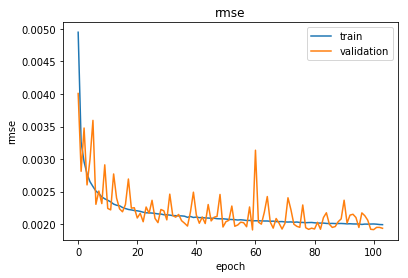

In [20]:
# plot training curve for rmse
plt.plot(result.history['rmse'])
plt.plot(result.history['val_rmse'])
plt.title('rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

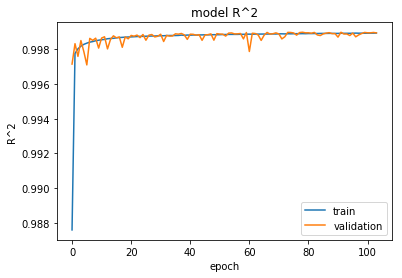

In [21]:
# plot training curve for R^2
plt.plot(result.history['r_square'])
plt.plot(result.history['val_r_square'])
plt.title('model R^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [22]:
import sklearn.metrics as skm, math
print("\n")
print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y_act,pre_act))
print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y_act,pre_act))
print("Root mean squared error (RMSE): %f" % math.sqrt(skm.mean_squared_error(y_act,pre_act)))
print("R square (R^2):                 %f" % skm.r2_score(y_act,pre_act))



Mean absolute error (MAE):      0.266426
Mean squared error (MSE):       0.199499
Root mean squared error (RMSE): 0.446653
R square (R^2):                 0.999030


## Try dropout

In [23]:
model2 = Sequential([
    Dense(64, activation='relu', input_shape=(6,)),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])
model2.compile(
  optimizer='adam',
  loss='mse',
  metrics=[rmse, r_square],
)
# fit the model
result2 = model2.fit(XX_train, 
                   yy_train,
                   epochs = 200,
                   batch_size=256,
                   validation_data=(XX_validation, yy_validation),
                   callbacks = [es]
                  )

W0703 10:12:23.443717  9196 deprecation.py:506] From C:\Users\mayingzh\AppData\Roaming\Python\Python36\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 1247590 samples, validate on 311898 samples
Epoch 1/200
1247590/1247590 [==============================] - 6s 5us/step - loss: 3.1954e-04 - rmse: 0.0085 - r_square: 0.9686 - val_loss: 3.3296e-04 - val_rmse: 0.0108 - val_r_square: 0.9680
Epoch 2/200
1247590/1247590 [==============================] - 6s 5us/step - loss: 3.8277e-05 - rmse: 0.0039 - r_square: 0.9962 - val_loss: 2.7505e-04 - val_rmse: 0.0094 - val_r_square: 0.9736
Epoch 3/200
1247590/1247590 [==============================] - 6s 5us/step - loss: 2.7840e-05 - rmse: 0.0033 - r_square: 0.9972 - val_loss: 3.2323e-04 - val_rmse: 0.0099 - val_r_square: 0.9691
Epoch 4/200
1247590/1247590 [==============================] - 7s 5us/step - loss: 2.4423e-05 - rmse: 0.0031 - r_square: 0.9976 - val_loss: 2.7081e-04 - val_rmse: 0.0089 - val_r_square: 0.9741
Epoch 5/200
1247590/1247590 [==============================] - 7s 5us/step - loss: 2.2799e-05 - rmse: 0.0030 - r_square: 0.9977 - val_loss: 1.9173e-04 - val_rmse: 0.0074 - val

1247590/1247590 [==============================] - 7s 5us/step - loss: 1.4936e-05 - rmse: 0.0024 - r_square: 0.9985 - val_loss: 1.6884e-04 - val_rmse: 0.0067 - val_r_square: 0.9840
Epoch 43/200
1247590/1247590 [==============================] - 6s 5us/step - loss: 1.4856e-05 - rmse: 0.0024 - r_square: 0.9985 - val_loss: 1.7948e-04 - val_rmse: 0.0068 - val_r_square: 0.9830
Epoch 44/200
1247590/1247590 [==============================] - 7s 5us/step - loss: 1.4868e-05 - rmse: 0.0023 - r_square: 0.9985 - val_loss: 1.7056e-04 - val_rmse: 0.0066 - val_r_square: 0.9839
Epoch 45/200
1247590/1247590 [==============================] - 7s 5us/step - loss: 1.4873e-05 - rmse: 0.0023 - r_square: 0.9985 - val_loss: 1.5184e-04 - val_rmse: 0.0061 - val_r_square: 0.9857
Epoch 46/200
1247590/1247590 [==============================] - 6s 5us/step - loss: 1.4825e-05 - rmse: 0.0023 - r_square: 0.9985 - val_loss: 1.8599e-04 - val_rmse: 0.0069 - val_r_square: 0.9824
Epoch 47/200
1247590/1247590 [=============

In [24]:
predictions2 = model2.predict(X_test)
pre_act2 = sc.inverse_transform(predictions2)
print(pre_act2[:10])
print("\n")
print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y_act,pre_act2))
print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y_act,pre_act2))
print("Root mean squared error (RMSE): %f" % math.sqrt(skm.mean_squared_error(y_act,pre_act2)))
print("R square (R^2):                 %f" % skm.r2_score(y_act,pre_act2))

[[2.3945363e-02]
 [8.6650796e-02]
 [1.2148048e+00]
 [2.1027565e+00]
 [6.0168069e-02]
 [1.1448849e+01]
 [2.6773474e+01]
 [7.4669123e+00]
 [9.2257805e+00]
 [4.3866779e+01]]


Mean absolute error (MAE):      0.894386
Mean squared error (MSE):       3.063334
Root mean squared error (RMSE): 1.750238
R square (R^2):                 0.985106


## Try batch normalization technique to regularize neurons

In [25]:
from keras.layers.normalization import BatchNormalization
model3 = Sequential([
    BatchNormalization(),
    Dense(64, activation='relu', input_shape=(6,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='linear'),
])
model3.compile(
  optimizer='adam',
  loss='mse',
  metrics=[rmse, r_square],
)
# fit the model
result3 = model3.fit(XX_train, 
                   yy_train,
                   epochs = 200,
                   batch_size=256,
                   validation_data=(XX_validation, yy_validation),
                   callbacks = [es]
                  )

Train on 1247590 samples, validate on 311898 samples
Epoch 1/200
1247590/1247590 [==============================] - 6s 5us/step - loss: 2.7744e-04 - rmse: 0.0098 - r_square: 0.9732 - val_loss: 1.4853e-04 - val_rmse: 0.0069 - val_r_square: 0.98560s - loss: 2.8614e-04 - rmse: 0.0100 - r_squ
Epoch 2/200
1247590/1247590 [==============================] - 6s 5us/step - loss: 1.8984e-04 - rmse: 0.0077 - r_square: 0.9816 - val_loss: 3.8211e-05 - val_rmse: 0.0043 - val_r_square: 0.9962
Epoch 3/200
1247590/1247590 [==============================] - 6s 5us/step - loss: 1.7847e-04 - rmse: 0.0074 - r_square: 0.9827 - val_loss: 8.9413e-05 - val_rmse: 0.0051 - val_r_square: 0.9914
Epoch 4/200
1247590/1247590 [==============================] - 6s 5us/step - loss: 1.7647e-04 - rmse: 0.0073 - r_square: 0.9828 - val_loss: 3.8152e-05 - val_rmse: 0.0040 - val_r_square: 0.9963
Epoch 5/200
1247590/1247590 [==============================] - 6s 5us/step - loss: 1.6909e-04 - rmse: 0.0071 - r_square: 0.9836 - v

Epoch 42/200
1247590/1247590 [==============================] - 7s 5us/step - loss: 1.5890e-04 - rmse: 0.0068 - r_square: 0.9845 - val_loss: 1.8180e-05 - val_rmse: 0.0029 - val_r_square: 0.9982
Epoch 43/200
1247590/1247590 [==============================] - 6s 5us/step - loss: 1.5557e-04 - rmse: 0.0067 - r_square: 0.9848 - val_loss: 3.7372e-05 - val_rmse: 0.0046 - val_r_square: 0.9963
Epoch 44/200
1247590/1247590 [==============================] - 6s 5us/step - loss: 1.5625e-04 - rmse: 0.0067 - r_square: 0.9849 - val_loss: 2.0732e-05 - val_rmse: 0.0027 - val_r_square: 0.9980
Epoch 45/200
1247590/1247590 [==============================] - 6s 5us/step - loss: 1.5813e-04 - rmse: 0.0068 - r_square: 0.9846 - val_loss: 3.8824e-05 - val_rmse: 0.0039 - val_r_square: 0.9962
Epoch 46/200
1247590/1247590 [==============================] - 7s 5us/step - loss: 1.5710e-04 - rmse: 0.0068 - r_square: 0.9847 - val_loss: 1.9647e-05 - val_rmse: 0.0029 - val_r_square: 0.9981
Epoch 47/200
1247590/1247590 [

In [26]:
predictions3 = model3.predict(X_test)
pre_act3 = sc.inverse_transform(predictions3)
print(pre_act3[:10])
print("\n")
print("Mean absolute error (MAE):      %f" % skm.mean_absolute_error(y_act,pre_act3))
print("Mean squared error (MSE):       %f" % skm.mean_squared_error(y_act,pre_act3))
print("Root mean squared error (RMSE): %f" % math.sqrt(skm.mean_squared_error(y_act,pre_act3)))
print("R square (R^2):                 %f" % skm.r2_score(y_act,pre_act3))

[[1.1319169e-02]
 [1.1319169e-02]
 [1.6107333e+00]
 [2.3785949e+00]
 [1.1319169e-02]
 [1.2584320e+01]
 [3.0258856e+01]
 [8.5781956e+00]
 [7.5245323e+00]
 [4.9345730e+01]]


Mean absolute error (MAE):      0.466450
Mean squared error (MSE):       0.609467
Root mean squared error (RMSE): 0.780684
R square (R^2):                 0.997037


## Reference: 
&emsp;&emsp;What does 'Accuracy' mean in Regression? https://github.com/keras-team/keras/issues/7947 <br>
&emsp;&emsp;https://keras.io/metrics/<br>
&emsp;&emsp;Scale, Standardize, or Normalize with Scikit-Learn https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02 <br>
&emsp;&emsp;The Day my Computer Won the Nobel Prize (Neural Network Option Pricing)  https://medium.com/datadriveninvestor/the-day-my-computer-won-the-nobel-prize-neural-network-option-pricing-d29b4379f1d2 <br>